In [2]:
import torch
import torchvision
from torch import nn

from torchvision import datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt

torch.__version__

'2.2.1+cu121'

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Data Setup


In [11]:
# DIRECTORY INFORMATION
from pathlib import Path
from helper_functions import walk_through_dir

image_path = Path("data/vehicle_images")
image_path_list = list(image_path.glob("*/*/*.jpg"))

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\vehicle_images'.
There are 2 directories and 0 images in 'data\vehicle_images\test'.
There are 0 directories and 51 images in 'data\vehicle_images\test\four wheeler'.
There are 0 directories and 82 images in 'data\vehicle_images\test\two wheeler'.
There are 2 directories and 0 images in 'data\vehicle_images\train'.
There are 0 directories and 207 images in 'data\vehicle_images\train\four wheeler'.
There are 0 directories and 348 images in 'data\vehicle_images\train\two wheeler'.


In [9]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/vehicle_images/train'),
 WindowsPath('data/vehicle_images/test'))

### 1.1 Downloading Weights of MobileNet and checking Transformations


In [12]:
# Transformation which is required for transfer learning with Pytorch models
manual_transform = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


from torchvision import models

weights = models.MobileNet_V3_Large_Weights.DEFAULT
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


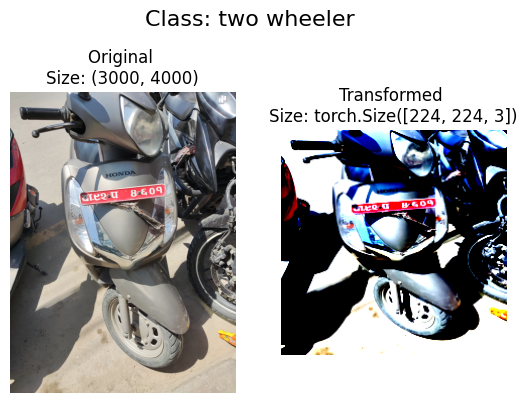

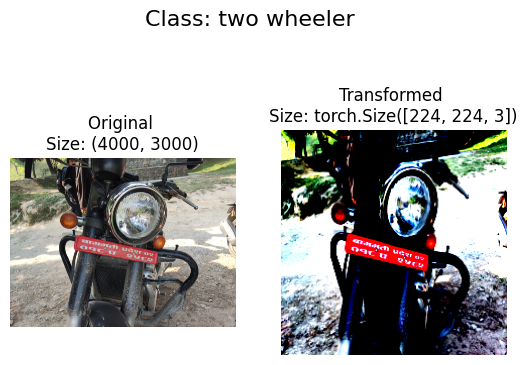

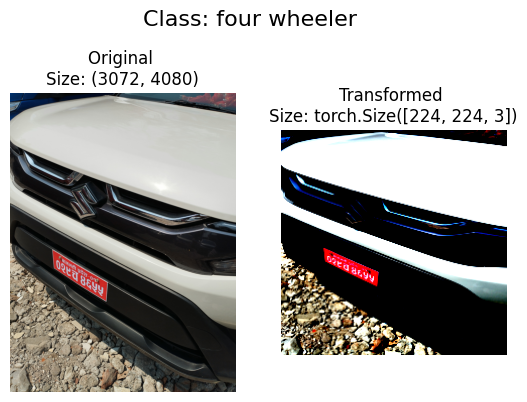

In [13]:
# VISUALIZING TRANSFORMED IMAGES
from helper_functions import plot_transformed_images

plot_transformed_images(image_path_list, manual_transform)

### 1.2 Setting up data features/labels and loaders


In [14]:
# Loading test and train data with the required transformations
train_data = datasets.ImageFolder(train_dir, transform=manual_transform)
test_data = datasets.ImageFolder(test_dir, transform=manual_transform)
class_names = train_data.classes

len(train_data), len(test_data), class_names

(555, 133, ['four wheeler', 'two wheeler'])

In [15]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

torch.manual_seed(42)
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x1f4c0884c50>,
 <torch.utils.data.dataloader.DataLoader at 0x1f4c088d6d0>)

## 2. Instantiating Model from torchvision.models


In [16]:
weightsv2 = models.MobileNet_V2_Weights.DEFAULT
weightsv3 = models.MobileNet_V3_Large_Weights.DEFAULT
weightsv3_small = models.MobileNet_V3_Small_Weights.DEFAULT
modelv2 = models.mobilenet_v2(weights=weightsv2).to(device)
modelv3 = models.mobilenet_v3_large(weights=weightsv3).to(device)
modelv3_small = models.mobilenet_v3_small(weights=weightsv3_small).to(device)
modelv3

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [17]:
from torchinfo import summary

summary(
    modelv3,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)  # LARGE

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 960, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 16, 112, 112]   432                  True
│    │    └─BatchNorm2d (1)                                  [32, 16, 112, 112]   [32, 16, 112, 112]   32                   True
│    │    └─Hardswish (2)                                    [32, 16, 112, 112]   [32, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32, 16, 112

### 2.1 Freezing layers and re-defining the last layer


In [18]:
for param in modelv3.features.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
modelv3.classifier = nn.Sequential(
    nn.Linear(
        in_features=960,
        out_features=1280,  # same number of output units as our number of classes
        bias=True,
    ),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(
        in_features=1280,
        out_features=output_shape,  # same number of output units as our number of classes
        bias=True,
    ),
).to(device)

#      Modelv3 Classifier Layer
#     (0)Linear(in_features=960, out_features=1280, bias=True)
#     (1): Hardswish()
#     (2): Dropout(p=0.2, inplace=True)
#     (3): Linear(in_features=1280, out_features=1000, bias=True)

## 3.Training Time


In [19]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelv3.parameters(), lr=0.001)

In [21]:
import engine  # contains our training functions

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Setup training and save the results
results = engine.train(
    model=modelv3,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=3,
    device=device,
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\nishc\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))
c:\Users\nishc\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\JpegImagePlugin.py:853: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch: 1 | train_loss: 0.1674 | train_acc: 0.9149 | test_loss: 0.0391 | test_acc: 0.9938
Epoch: 2 | train_loss: 0.0166 | train_acc: 0.9915 | test_loss: 0.0095 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0057 | train_acc: 1.0000 | test_loss: 0.0029 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0058 | train_acc: 0.9983 | test_loss: 0.0099 | test_acc: 0.9938
Epoch: 5 | train_loss: 0.0052 | train_acc: 0.9965 | test_loss: 0.0027 | test_acc: 1.0000
[INFO] Total training time: 574.082 seconds


In [22]:
# Saving trained model
from utils import save_model

save_model(modelv3, "data/saved_models", "modelv3_large.pth")

[INFO] Saving model to: data\saved_models\modelv3_large.pth


In [25]:
# Testing Loading model
modelv3_load = modelv3
modelv3_load.load_state_dict(torch.load("data/saved_models/modelv3_large.pth"))

<All keys matched successfully>

### 3.1 Loss Curves


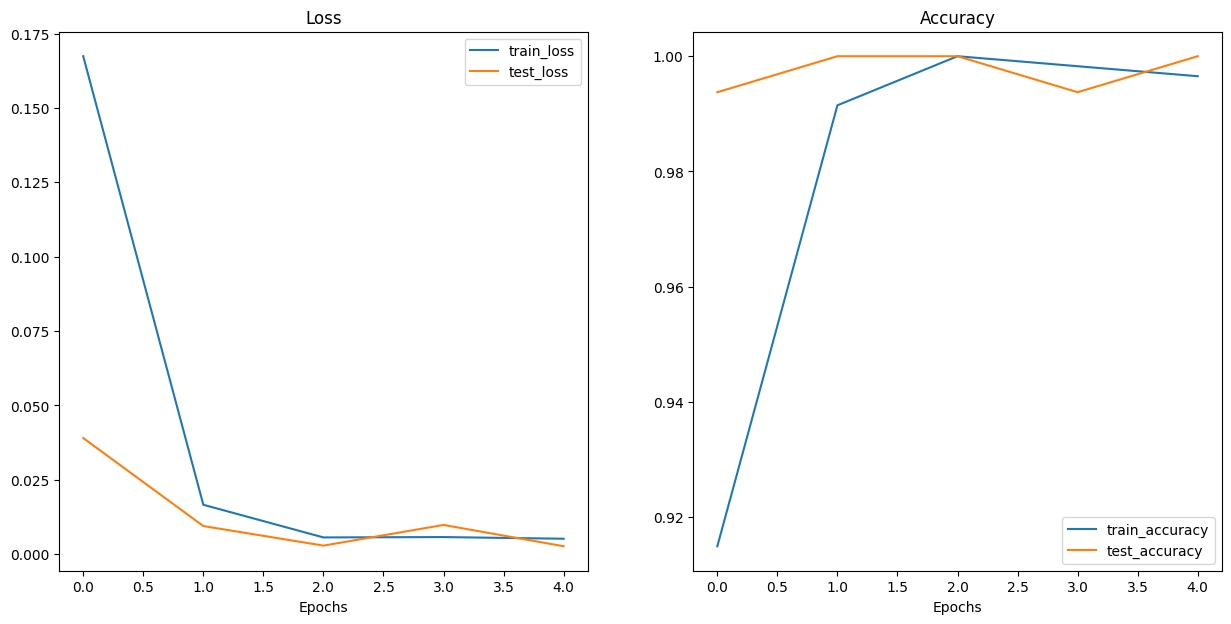

In [26]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 4. Evaluating Predictions on Unseen Data


In [27]:
manual_transform_noNormalize = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    ]
)

In [55]:
# Loading unseen data from directory
new_dir = "data/unseen"
unseen_dataset = datasets.ImageFolder(new_dir, transform=manual_transform_noNormalize)
unseen_loader = DataLoader(
    unseen_dataset,
    shuffle=False,
)

# Get samples and labels from the unseen data in different lists
test_samples = []
test_labels = []
for sample, label in unseen_loader:
    test_samples.append(sample)
    test_labels.append(label.item())
test_labels

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [29]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = sample.to(device)  # Add an extra dimension for batch

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(
                pred_logit, dim=1
            )  # Perform softmax on the channel dimension

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.cat(pred_probs, dim=0)


pred_probs = make_predictions(model=modelv3, data=test_samples)
# Converting prediction probabilities into labels
pred_labels = pred_probs.argmax(dim=1)
pred_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [30]:
correct = 0
total = 0
for i in pred_labels:
    if pred_labels[i] == test_labels[i]:
        correct += 1
    total += 1
accuracy = correct / total * 100
print(f"Accuracy on unseen images: {accuracy:.2f}%")

Accuracy on unseen images: 100.00%


### 4.1 Subplots for Unseen Predictions


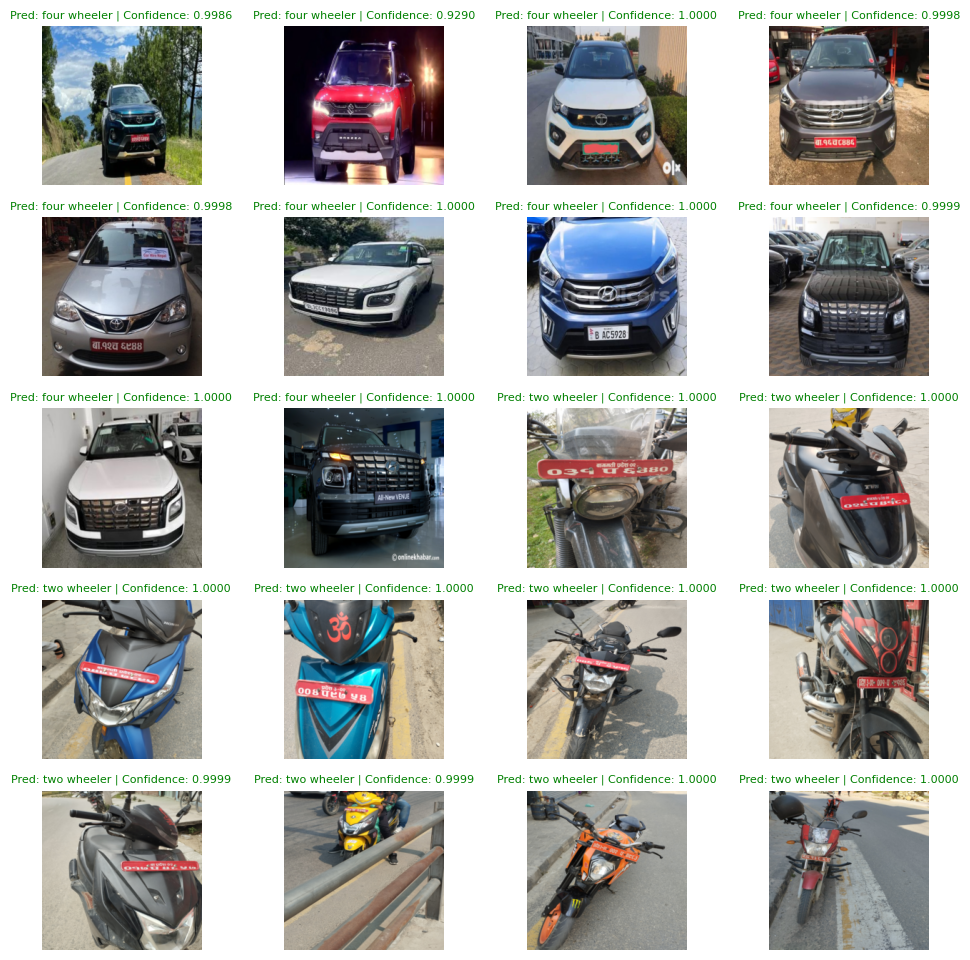

In [31]:
# Plot predictions
plt.figure(figsize=(12, 12))
nrows = 5
ncols = 4
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    sample = sample.squeeze()
    plt.title("SCORE: {accuracy}%")
    plt.imshow(sample.permute(1, 2, 0))

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_labels[i].item()]
    truth_label = class_names[test_labels[i]]

    # Get the confidence score for the prediction from pred_probs
    confidence = torch.max(pred_probs[i]).item()

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Confidence: {confidence:.4f}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=8, c="g")  # green text if correct
    else:
        plt.title(title_text, fontsize=8, c="r")  # red text if wrong
    plt.axis(False)

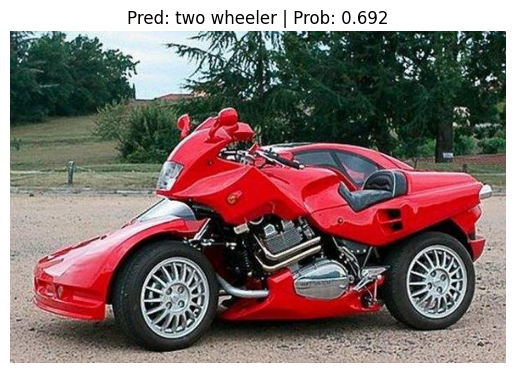

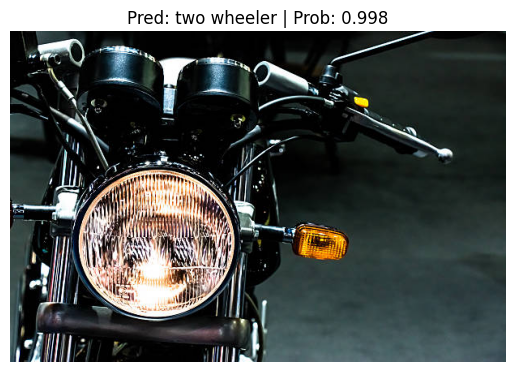

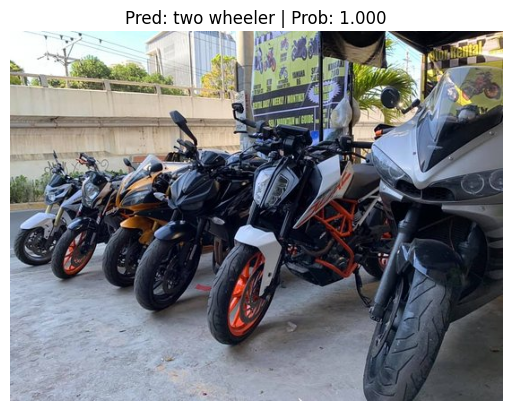

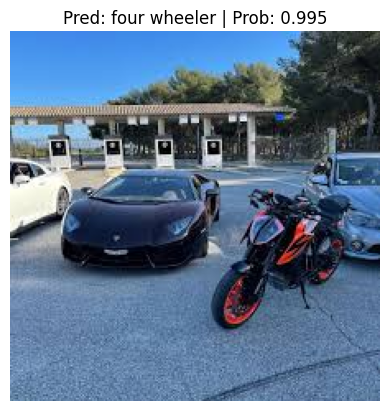

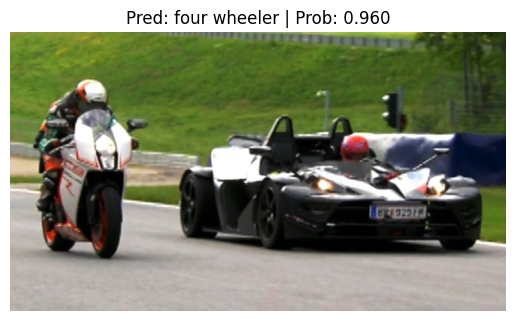

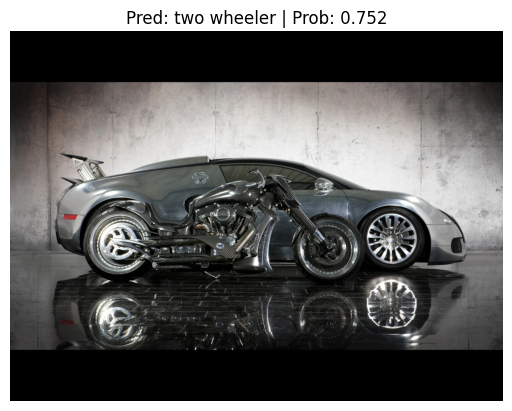

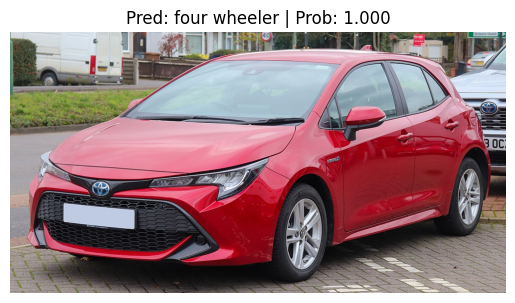

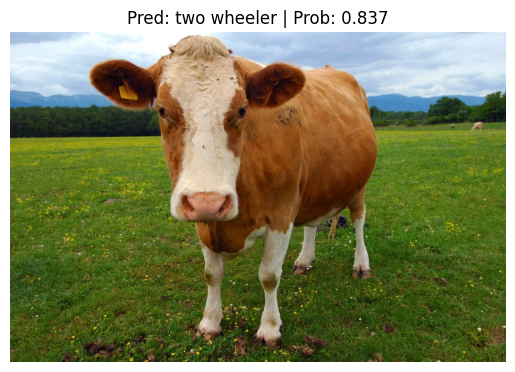

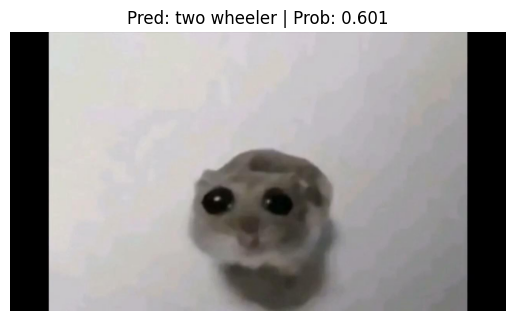

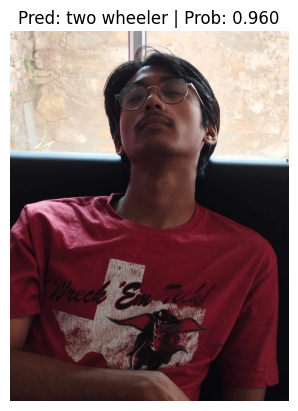

In [99]:
from pathlib import Path
from predictions import pred_and_plot_image



test_dir = "data/custom"



dir_path = list(Path(test_dir).glob("*.jpg"))


for image in dir_path:

    pred_and_plot_image(
        image_path=image,
        model=modelv3,
        class_names=class_names,
        device=device,
        image_size=(224, 224),
    )